In [1]:
import pandas as pd
pd.set_option('max_colwidth',200)
import numpy as np
import os
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt

### 收集数据
#### WeRateDog的twitter档案

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')


#### twitter图像预测数据

In [3]:
# download the file of image predictions from the URL

url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
        file.write(response.content)
        

In [4]:
# upload the date from the file
image_predictions = pd.read_csv(url.split('/')[-1], sep='\t')


#### twitter附加数据

##### get twitter API
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


##### find the twitter content
for tweet_id in twitter_archive['tweet_id']:
    try:
        # download the content of the specific id
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        # append data into txt
        with open('tweet_json.txt', 'w') as f:
            f.write(json.dump(tweet, f, ensure_ascii=False))
    # not best practice to catch all exceptions        
    except Exception as e:
        print('%: The content of % has been deleted'.format(e, tweet_id))
        

In [5]:
# read txt data to build a list of dictionary
json_list = []

with open('tweet_json.txt', 'r') as f:
    for line in f.readlines():
        df = json.loads(line)

        json_list.append(df)


In [6]:
# create DataFrame from list of dictionary
df_list = []
for item in json_list:
    tweet_ID = item['id']
    retweet_count = item['retweet_count']
    favorite_count = item['favorite_count']
    
    df_list.append({'tweet_id': tweet_ID,
                   'retweet_count': retweet_count,
                   'favorite_count': favorite_count})
    
tweet_extra_data = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])


###### json文件的简单读取方式
df_json = pd.read_json('tweet_json.txt',lines=True)[['id', 'retweet_count', 'favorite_count']]
df_json.columns = ['tweet_id', 'retweet_count', 'favorite_count']'''

### 数据评估

通过目测评估和编程评估的方式对数据进行质量及整洁度的评估

#### 质量 quality  

*twitter_archive table*
* 'tweet_id' is an int not a string
* The columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' have too much missing data 
* The dataset doesn't need retweet contents
* 'timestamp' is a string not a datatype and contains '+0000'
* 'source' includes useless infomation such like http link
* 'expanded_urls' has null value in a row
* Min and max numbers of the 'rating_numerator' and 'rating_denominator' are not correct
* Many None or a/an in 'name'
* 'doggo', 'floofer', 'pupper', 'puppo' contain too many None
* Delete the data after 8/1/2017

*image_predictions table*
* 'tweet_id' and 'img_num' is an int not a string
* The duplicates in 'jpg_url' column

*tweet_extra_data table*
* 'tweet_id' is an int not a string


#### 整洁度 tidiness
* Dog stage is in four different columns (doggo, floofer, pupper, puppo)
* Three tables can be merged


In [7]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1191,717841801130979328,NaN,NaN,2016-04-06 22:29:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Barclay. His father was a banana. 11/10 appeeling af https://t.co/ucOEfr2rjV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717841801130979328/photo/1,11,10,Barclay,None,None,None,None
1884,674800520222154752,NaN,NaN,2015-12-10 03:59:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tedders. He broke his leg saving babies from the Pompeii eruption. 11/10 where's his Purple Heart? @POTUS https://t.co/cMI2AcLm4B,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674800520222154752/photo/1,11,10,Tedders,None,None,None,None
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None
619,796149749086875649,NaN,NaN,2016-11-09 00:37:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ruby. She just turned on the news. Officially terrified. 11/10 deep breaths Ruby https://t.co/y5KarNXWXt,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/796149749086875649/photo/1,https://twitter.com/dog_rates/status/796149749086875649/photo/1",11,10,Ruby,None,None,None,None
1031,745422732645535745,NaN,NaN,2016-06-22 01:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10 https://t.co/nc53zEN0hZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745422732645535745/photo/1,9,10,very,None,None,None,None


In [8]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2153,669661792646373376,NaN,NaN,2015-11-25 23:39:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a brave dog. Excellent free climber. Trying to get closer to God. Not very loyal though. Doesn't bark. 5/10 https://t.co/ODnILTr4QM,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669661792646373376/photo/1,5,10,a,None,None,None,None
1497,692423280028966913,6.924173e+17,4.196984e+09,2016-01-27 19:05:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PUPDATE: just noticed this dog has some extra legs. Very advanced. Revolutionary af. Upgraded to a 9/10,NaN,NaN,NaN,NaN,9,10,None,None,None,None,None
629,794355576146903043,NaN,NaN,2016-11-04 01:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Butter. She can have whatever she wants forever. 12/10 would hug softly https://t.co/x5gXRS1abq,7.887659e+17,4.196984e+09,2016-10-19 15:37:03 +0000,"https://twitter.com/dog_rates/status/788765914992902144/photo/1,https://twitter.com/dog_rates/status/788765914992902144/photo/1",12,10,Butter,None,None,None,None
1878,675047298674663426,NaN,NaN,2015-12-10 20:19:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a fluffy albino Bacardi Columbia mix. Excellent at the tweets. 11/10 would hug gently https://t.co/diboDRUuEI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675047298674663426/photo/1,11,10,a,None,None,None,None
731,781655249211752448,NaN,NaN,2016-09-30 00:41:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Combo. The daily struggles of being a doggo have finally caught up with him. 11/10 https://t.co/LOKrNo0OM7,NaN,NaN,NaN,https://vine.co/v/5rt6T3qm7hL,11,10,Combo,doggo,None,None,None


In [11]:
twitter_archive['name'].value_counts()

None            745
a                55
Charlie          12
Cooper           11
Lucy             11
Oliver           11
Penny            10
Tucker           10
Lola             10
Winston           9
Bo                9
Sadie             8
the               8
an                7
Toby              7
Daisy             7
Bailey            7
Buddy             7
Scout             6
Jack              6
Leo               6
Rusty             6
Bella             6
Oscar             6
Milo              6
Jax               6
Stanley           6
Dave              6
Koda              6
very              5
               ... 
Aja               1
unacceptable      1
Creg              1
Georgie           1
Nimbus            1
Monster           1
Eleanor           1
Cilantro          1
Fido              1
Grizz             1
Orion             1
Sundance          1
Laela             1
Zara              1
Trevith           1
Maks              1
Freddery          1
Maxwell           1
Jareld            1


In [12]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1580,796387464403357696,https://pbs.twimg.com/media/Cw1WKu1UQAAvWsu.jpg,1,Pekinese,0.461164,True,Pomeranian,0.288650,True,Siamese_cat,0.052423,False
565,678278586130948096,https://pbs.twimg.com/media/CWm6xySUEAAqfFU.jpg,1,Maltese_dog,0.897841,True,Lhasa,0.035717,True,Tibetan_terrier,0.017107,True
326,671891728106971137,https://pbs.twimg.com/media/CVMJ9guXAAAhAiK.jpg,1,Labrador_retriever,0.567933,True,golden_retriever,0.349401,True,seat_belt,0.069396,False
579,678764513869611008,https://pbs.twimg.com/media/CWt0ubZWcAAkFER.jpg,1,Irish_terrier,0.696646,True,Australian_terrier,0.074962,True,Irish_setter,0.063901,True
1098,720389942216527872,https://pbs.twimg.com/media/Cf9W1J-UMAErahM.jpg,1,Pembroke,0.873977,True,Cardigan,0.043339,True,Eskimo_dog,0.019197,True
698,684567543613382656,https://pbs.twimg.com/media/CYASi6FWQAEQMW2.jpg,1,minibus,0.401942,False,llama,0.229145,False,seat_belt,0.209393,False
36,666447344410484738,https://pbs.twimg.com/media/CT-yU5QWwAEjLX5.jpg,1,curly-coated_retriever,0.322084,True,giant_schnauzer,0.287955,True,Labrador_retriever,0.166331,True
1450,776218204058357768,https://pbs.twimg.com/media/CsWuVEdWcAAqbe9.jpg,1,Samoyed,0.940326,True,Pomeranian,0.055527,True,keeshond,0.002226,True
49,666835007768551424,https://pbs.twimg.com/media/CUES51dXIAEahyG.jpg,1,Airedale,0.448459,True,toy_poodle,0.124030,True,teddy,0.110183,False
1757,825147591692263424,https://pbs.twimg.com/media/C3ODWpfXAAAP1fb.jpg,1,Pekinese,0.354823,True,Pomeranian,0.245390,True,toy_poodle,0.136545,True


In [15]:
image_predictions[image_predictions.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [16]:
tweet_extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [17]:
tweet_extra_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.352000e+03,2352.000000,2352.000000
mean,7.425913e+17,3134.932398,8109.198980
std,6.846210e+16,5237.846296,11980.795669
min,6.660209e+17,0.000000,0.000000
25%,6.783949e+17,618.000000,1417.000000
50%,7.193536e+17,1456.500000,3596.500000
75%,7.991219e+17,3628.750000,10118.000000
max,8.924206e+17,79116.000000,132318.000000


In [18]:
tweet_extra_data.sample(10)

,tweet_id,retweet_count,favorite_count
1393,699779630832685056,1393,3028
2289,667152164079423490,18176,49523
171,858107933456039936,3140,16459
1705,680609293079592961,811,2888
1024,745789745784041472,1201,4413
1655,683098815881154561,734,2351
2169,669324657376567296,222,520
588,799063482566066176,2852,9024
1755,678740035362037760,1920,4086
2350,666029285002620928,48,132


### 数据清理


In [19]:
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_extra_data_clean = tweet_extra_data.copy()

#### 缺失数据

`twitter_archive`: 
* The columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' have too much missing data. 
* The dataset doesn't need retweet contents

###### define

* Delete the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'
* Delete the rows including the 'in_reply_to_status_id' and 'retweeted_status_user_id'

###### code

In [20]:
# Delete the rows including the 'in_reply_to_status_id' and 'retweeted_status_user_id'

twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_user_id'].isnull()]

In [21]:
# Delete the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'

twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                            'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

###### test

In [22]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2044,671533943490011136,2015-12-01 03:39:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Super rare dog here. Spiffy mohawk. Sharp mouth. Shits eggs. Cool chariot wheel in background. 6/10 v confident pup https://t.co/pcx8jm1J1K,https://twitter.com/dog_rates/status/671533943490011136/photo/1,6,10,None,None,None,None,None
2202,668643542311546881,2015-11-23 04:13:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Fascinating dog here. Loves beach. Oddly long nose for dog. Massive ass paws. Hard to cuddle w. 3/10 would still pet https://t.co/IiSdmhkC5N,https://twitter.com/dog_rates/status/668643542311546881/photo/1,3,10,None,None,None,None,None
1322,706291001778950144,2016-03-06 01:31:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're just relaxin and having a swell time but then remember you have to fill out the FAFSA ...11/10 https://t.co/qy33OBcexg,"https://twitter.com/dog_rates/status/706291001778950144/photo/1,https://twitter.com/dog_rates/status/706291001778950144/photo/1",11,10,None,None,None,None,None
585,800018252395122689,2016-11-19 16:49:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo doin a struggle. 11/10 much determined https://t.co/gQqRBfkX4I,https://twitter.com/dog_rates/status/800018252395122689/video/1,11,10,None,doggo,None,None,None
493,813202720496779264,2016-12-26 02:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo who has concluded that Christmas is entirely too bright. Requests you tone it down a notch. 11/10 https://t.co/cD967DjnIn,https://twitter.com/dog_rates/status/813202720496779264/photo/1,11,10,None,doggo,None,None,None


##### Tidiness


`twitter_archive`:
* Dog stage is in four different columns (doggo, floofer, pupper, puppo)

###### define

* Find the stage from the text
* Delete the 'doggo', 'floofer', 'pupper', 'puppo' columns

###### code

In [23]:
# Find the stage from the text
twitter_archive_clean['stage'] = twitter_archive_clean.text.str.lower().str.findall('(doggo|floofer|pupper|puppo)')

# Transfer 'stage' list to string
twitter_archive_clean['stage'] = twitter_archive_clean.stage.str.join(',')


In [24]:
# Delete the 'doggo', 'floofer', 'pupper', 'puppo' columns
twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### test

In [25]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
176,857746408056729600,2017-04-28 00:00:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Thor. He doesn't have finals because he's a dog but is pupset you have finals. Just wants to play. 13/10 would abandon education for https://t.co/7IFn3rkJai,"https://twitter.com/dog_rates/status/857746408056729600/photo/1,https://twitter.com/dog_rates/status/857746408056729600/photo/1,https://twitter.com/dog_rates/status/857746408056729600/photo/1",13,10,Thor,
1472,693942351086120961,2016-01-31 23:42:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kobe. He's a Speckled Rorschach. Requests that someone holds his hand during car rides. 10/10 sick interior https://t.co/LCA6Fr3X2M,https://twitter.com/dog_rates/status/693942351086120961/photo/1,10,10,Kobe,
1787,677565715327688705,2015-12-17 19:07:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Contortionist pup here. Inside pentagram. Clearly worships Satan. Known to slowly push fragile stuff off tables 6/10 https://t.co/EX9oR55VMe,https://twitter.com/dog_rates/status/677565715327688705/photo/1,6,10,None,
1165,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,
699,786286427768250368,2016-10-12 19:24:27 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Arnie. He's afraid of his own bark. 12/10 would comfort https://t.co/ObT2tSxXit,https://vine.co/v/5XH0WqHwiFp,12,10,Arnie,


In [26]:
twitter_archive_clean['stage'].value_counts()

                             1723
pupper                        236
doggo                          77
puppo                          28
pupper,pupper                   9
floofer                         9
doggo,pupper                    5
pupper,doggo                    3
doggo,doggo                     2
pupper,pupper,pupper            1
puppo,doggo                     1
pupper,doggo,pupper,doggo       1
doggo,floofer                   1
puppo,doggo,puppo               1
Name: stage, dtype: int64

In [27]:
twitter_archive_clean.to_csv('test.csv')

##### redefine
* Check the text again and find the reasons
* If the stages are the same then keep it.
* If there are two or more stages in a text which there are two or more dogs so that delete it.

##### code

In [28]:
# change the stage status
twitter_archive_clean['stage'].replace({'pupper,pupper':'pupper', 'doggo,doggo': 'doggo', 
                                        'pupper,pupper,pupper': 'pupper'}, inplace=True)

In [29]:
# delete the rows which stage contains two or more stages.
twitter_archive_clean = twitter_archive_clean[(~twitter_archive_clean.stage.str.contains(','))]

##### test

In [30]:
twitter_archive_clean['stage'].value_counts()

           1723
pupper      246
doggo        79
puppo        28
floofer       9
Name: stage, dtype: int64

##### merge three tables at the final step

#### Quality

#### `twitter_archive` & `image_predictions` & `tweet_extra_data`:
* 'tweet_id' is an int not a string

###### define

* Cover the 'tweet_id' column's data from float to a string

###### code

In [31]:
# Cover the 'tweet_id' column's data from float to a string
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
tweet_extra_data_clean['tweet_id'] = tweet_extra_data_clean['tweet_id'].astype(str)

##### test

In [32]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2085 non-null object
timestamp             2085 non-null object
source                2085 non-null object
text                  2085 non-null object
expanded_urls         2082 non-null object
rating_numerator      2085 non-null int64
rating_denominator    2085 non-null int64
name                  2085 non-null object
stage                 2085 non-null object
dtypes: int64(2), object(7)
memory usage: 162.9+ KB


In [33]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB



#### `twitter_archive`:
* 'timestamp' is a string not a datatype


##### define
* Slice the 'timestamp' without +0000
* Cover the 'timestamp' column's data from string to datatime

##### code

In [34]:
# Slice the 'timestamp' without +0000
# Cover the 'timestamp' column's data from string to datatime
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp[:-6])

##### test

In [35]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,


In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2085 non-null object
timestamp             2079 non-null datetime64[ns]
source                2085 non-null object
text                  2085 non-null object
expanded_urls         2082 non-null object
rating_numerator      2085 non-null int64
rating_denominator    2085 non-null int64
name                  2085 non-null object
stage                 2085 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 162.9+ KB


#### `twitter_archive`:
* 'source' includes useless infomation such like http link

##### define
* Just cut out the info of where the source comes, such like Twitter for iPhone, Twitter Web Client and Vine - Make a Scene

##### code

In [37]:
twitter_archive_clean['source'] = twitter_archive_clean.source.str.extract('(>(.+)<)', expand=True)
twitter_archive_clean['source'] = twitter_archive_clean.source.str.extract('([A-Z]\D+[a-z])', expand=True)

##### test

In [38]:
twitter_archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
719,783391753726550016,2016-10-04 19:42:03,Twitter for iPhone,Meet Godi. He's an avid beachgoer and part time rainbow summoner. Eyeliner flawless af. 13/10 would snug well https://t.co/BO936YdJdi,"https://twitter.com/dog_rates/status/783391753726550016/photo/1,https://twitter.com/dog_rates/status/783391753726550016/photo/1,https://twitter.com/dog_rates/status/783391753726550016/photo/1,http...",13,10,Godi,


#### `twitter_archive`:
* 'expanded_urls' has null value in a row

##### define
* Keep the rows which is not null using `notnull()`

##### code

In [39]:
# Keep the rows which is not null using notnull()

twitter_archive_clean[twitter_archive_clean['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
375,828361771580813312,2017-02-05 21:56:51,Twitter Web Client,Beebop and Doobert should start a band 12/10 would listen,NaN,12,10,None,
707,785515384317313025,2016-10-10 16:20:36,Twitter for iPhone,"Today, 10/10, should be National Dog Rates Day",NaN,10,10,None,
1445,696518437233913856,2016-02-08 02:18:30,Twitter for iPhone,Oh my god 10/10 for every little hot dog pupper,NaN,10,10,None,pupper


In [40]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['expanded_urls'].notnull()]

#####  测试

In [41]:
twitter_archive_clean['expanded_urls'].value_counts()

https://vine.co/v/ea0OwvPTx9l                                                                                                                                                                                                                                      2
https://twitter.com/dog_rates/status/698953797952008193/photo/1                                                                                                                                                                                                    1
https://twitter.com/dog_rates/status/709158332880297985/photo/1                                                                                                                                                                                                    1
https://twitter.com/dog_rates/status/667192066997374976/photo/1                                                                                                                                                          

In [42]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
1920,674265582246694913,2015-12-08 16:33:36,Twitter for iPhone,This is Henry. He's a shit dog. Short pointy ears. Leaves trail of pee. Not fluffy. Doesn't come when called. 2/10 https://t.co/Pu9RhfHDEQ,https://twitter.com/dog_rates/status/674265582246694913/photo/1,2,10,Henry,
1409,699060279947165696,2016-02-15 02:38:53,Vine - Make a Scene,This is Yukon. He pukes rainbows. 12/10 magical af https://t.co/n6wND1v7il,https://vine.co/v/inlmMHxtqDD,12,10,Yukon,
1588,686730991906516992,2016-01-12 02:06:41,Twitter for iPhone,I just love this picture. 12/10 lovely af https://t.co/Kc84eFNhYU,https://twitter.com/dog_rates/status/686730991906516992/photo/1,12,10,None,
1928,674045139690631169,2015-12-08 01:57:39,Twitter for iPhone,Herd of wild dogs here. Not sure what they're trying to do. No real goals in life. 3/10 find your purpose puppers https://t.co/t5ih0VrK02,https://twitter.com/dog_rates/status/674045139690631169/photo/1,3,10,None,pupper
1031,745422732645535745,2016-06-22 01:06:43,Twitter for iPhone,We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10 https://t.co/nc53zEN0hZ,https://twitter.com/dog_rates/status/745422732645535745/photo/1,9,10,very,


#### `twitter_archive`:
* Min and max numbers of the 'rating_numerator' and 'rating_denominator' are not correct

##### define
* Reselect the rating numbers from the texts
* Check the outlier
* If the denominator is not 10, double check the text or delete the row

##### code

在这个数据集中，评分存在以下问题：  
1）分子是小数，但是只提取了小数点后面的数字的情况，比如 11.26/10，提取为了 26/10；  
2）多只狗狗评的总分：99/90，规律是：分母是10的N倍，且分子可以被 N 整除；  
3）同一个推特中存在两处分数形式的数字，提取的是第一个，但是可能第二个才是正确的：@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho  
4）比较单独的错误，比如 24/7 指的是7天 24 小时，并不是一个评分，这条推文中也没有具体的评分，可以 drop 掉；  

In [43]:
# 提取出的分子是带有小数点的，分母是10的倍数
rating = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/([1-9]+[0]+)', expand = True)
# 提取出来的结果是个 dataframe 数据集，有两列，分别命名为分子和分母
rating.columns = ['rating_numerator', 'rating_denominator']
# 用新提取的数据替换掉原有的数据，记得修改分子的类型
twitter_archive_clean['rating_numerator'] = rating['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = rating['rating_denominator'].astype(float)

当然，这样重新提取后，还是可能存在一个推文中有多个评分的情况，针对有多个分数的情况，因为具体涉及到的问题不同，我们可以使用 findall 找出所有 text 中有多个分数的数据，然后将其筛选出来，查看具体是哪种情况，单独处理：

In [44]:
# 检查提取了两个 score 的情况
twitter_archive_clean['scores'] = twitter_archive_clean.text.str.findall('((?:\d+\.)?\d+\/[1-9]+[0]+)')
twitter_archive_clean['score_counts'] = twitter_archive_clean['scores'].apply(lambda x: len(set(x)))
twitter_archive_clean[twitter_archive_clean['score_counts']>1][['text','scores','score_counts']]

,text,scores,score_counts
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ","[12/10, 11/10]",2
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,"[10/10, 7/10]",2
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,"[4/20, 13/10]",2
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,"[50/50, 11/10]",2
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,"[10/10, 8/10]",2
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,"[9/10, 2/10]",2
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P","[4/10, 13/10]",2
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,"[10/10, 5/10]",2
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,"[5/10, 10/10]",2
1525,This is Eriq. His friend just reminded him of last year's super bowl. Not cool friend\n10/10 for Eriq\n6/10 for friend https://t.co/PlEXTofdpf,"[10/10, 6/10]",2


In [45]:
## 1776/10, 420/10 are correct so keep it
## 26/10, 75/10, 27/10 are only keep the float of the numerators
twitter_archive_clean['rating_numerator'].replace({26: 11.26, 75: 9.75, 27: 11.27}, inplace=True)

如果在清理后，想要将一些多个狗狗总评分的数据，修改为分母为 10 的模式，可以直接使用向量运算：

In [46]:
twitter_archive_clean['rating_numerator']  = twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator'] *10

In [47]:
## delete the rows when rating_denominator is not 10
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 10]

In [48]:
## delete scores and score_counts
twitter_archive_clean.drop(['scores', 'score_counts'], axis=1, inplace=True)

##### test

In [49]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
1028,745789745784041472,2016-06-23 01:25:06,Twitter for iPhone,This is Gus. He didn't win the Powerball. Quite perturbed about it. Still 10/10 would comfort in time of need https://t.co/3wc246LOtu,https://twitter.com/dog_rates/status/745789745784041472/photo/1,10.0,10.0,Gus,
2080,670823764196741120,2015-11-29 04:37:03,Twitter for iPhone,This is Remington. He's a man dime. 12/10 https://t.co/m3ufSDwHHJ,https://twitter.com/dog_rates/status/670823764196741120/photo/1,12.0,10.0,Remington,
752,778990705243029504,2016-09-22 16:13:51,Twitter for iPhone,This is Jay. He's really h*ckin happy about the start of fall. Sneaky tongue slip in 2nd pic. 11/10 snuggly af https://t.co/vyx1X5eyWI,"https://twitter.com/dog_rates/status/778990705243029504/photo/1,https://twitter.com/dog_rates/status/778990705243029504/photo/1",11.0,10.0,Jay,
1448,696405997980676096,2016-02-07 18:51:43,Twitter for iPhone,This is Berb. He just found out that they have made 31 Kidz Bop CD's. Downright terrifying. 7/10 hang in there Berb https://t.co/CIFLjiTFwZ,https://twitter.com/dog_rates/status/696405997980676096/photo/1,7.0,10.0,Berb,
776,776113305656188928,2016-09-14 17:40:06,Twitter for iPhone,This is Sampson. He's about to get hit with a vicious draw 2. Has no idea. 11/10 poor pupper https://t.co/FYT9QBEnKG,https://twitter.com/dog_rates/status/776113305656188928/photo/1,11.0,10.0,Sampson,pupper


In [50]:
twitter_archive_clean['rating_numerator'].value_counts()

12.00      479
10.00      434
11.00      412
13.00      284
9.00       153
8.00        98
7.00        51
14.00       39
5.00        32
6.00        32
3.00        19
4.00        15
2.00         9
1.00         4
11.26        1
0.00         1
11.27        1
420.00       1
13.50        1
9.75         1
1776.00      1
Name: rating_numerator, dtype: int64

In [51]:
twitter_archive_clean['rating_denominator'].value_counts()

10.0    2068
Name: rating_denominator, dtype: int64

#### `twitter_archive`:
* Many None or a/an in 'name'

##### define
* Reselect the name from the text

##### code

In [52]:
# check the text and find name usually following This is, named, Meet, Say hello to, name is, Here we have, Here is
# reselect the name from the text
twitter_archive_clean['name'] = twitter_archive_clean.text.str.extract(
    '(?:This is|named|Meet|Say hello to|name is|Here we have|Here is)\s([A-Z][a-z+]*)',expand=True)

##### test

In [53]:
twitter_archive_clean['name'].value_counts()

Lucy        11
Charlie     11
Oliver      10
Cooper      10
Penny        9
Tucker       9
Sadie        8
Winston      8
Lola         8
Daisy        7
Toby         7
Bailey       6
Stanley      6
Jax          6
Koda         6
Bella        6
Oscar        6
Bo           6
Louis        5
Leo          5
Milo         5
Bentley      5
Scout        5
Rusty        5
Dave         5
Zoey         5
Chester      5
Buddy        5
Jeffrey      4
Phil         4
            ..
Fizz         1
Sam          1
Furzey       1
Edgar        1
Fido         1
Maxwell      1
Freddery     1
Maks         1
Chelsea      1
Acro         1
Clarkus      1
Carbon       1
Eriq         1
Willem       1
Kody         1
Poppy        1
Trip         1
Aqua         1
Link         1
Jimbo        1
Cilantro     1
Grizz        1
Orion        1
Sundance     1
Binky        1
Zara         1
Trevith      1
Meyer        1
Cali         1
Sobe         1
Name: name, Length: 949, dtype: int64

In [54]:
twitter_archive_clean.head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,


#### `image_predictions`:
* The duplicates in 'jpg_url' column

##### define
* Delete the duplicates

##### code

In [55]:
# Delete the duplicates and only keep the first one
image_predictions_clean.drop_duplicates(['jpg_url'], inplace=True)

##### test

In [56]:
image_predictions_clean['jpg_url'].value_counts()

https://pbs.twimg.com/media/CVtvf6bWwAAd1rT.jpg                                            1
https://pbs.twimg.com/media/CdXY-GHWoAALing.jpg                                            1
https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg                                            1
https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg                                            1
https://pbs.twimg.com/media/CyeTku-XcAALkBd.jpg                                            1
https://pbs.twimg.com/media/CW8OYajUMAAPRoF.jpg                                            1
https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg                                            1
https://pbs.twimg.com/media/CpDNQGkWEAENiYZ.jpg                                            1
https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg                                            1
https://pbs.twimg.com/media/CU9LyIMWIAA6OOu.jpg                                            1
https://pbs.twimg.com/media/Cskh9nRWYAAUxBP.jpg                       

####  Tidiness
#### `twitter_archive` & `image_predictions` & `tweet_extra_data`:
* Three tables can be merged
* No need the data after 8/1/2017

##### define
* Merge three tables based on 'tweet_id'
* Delete the data after '2017-08-02 00:00:00'
* Drop unnecessary columns and change the heading names

##### code

In [57]:
# Merge three tables based on 'tweet_id'
# Only keep the data having pictures which means to inner join
wrd_clean = pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='inner')

wrd_clean = pd.merge(wrd_clean, tweet_extra_data_clean, on='tweet_id', how='left')

In [58]:
wrd_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8842,39492
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6480,33786
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4301,25445
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8925,42863
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9721,41016


In [59]:
# Delete 'text' and 'name'
wrd_clean.drop(['text'], axis=1, inplace=True)

##### test 

In [60]:
wrd_clean.head()

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8842,39492
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6480,33786
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4301,25445
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8925,42863
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9721,41016


In [61]:
wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 1945
Data columns (total 21 columns):
tweet_id              1946 non-null object
timestamp             1940 non-null datetime64[ns]
source                1946 non-null object
expanded_urls         1946 non-null object
rating_numerator      1946 non-null float64
rating_denominator    1946 non-null float64
name                  1373 non-null object
stage                 1946 non-null object
jpg_url               1946 non-null object
img_num               1946 non-null int64
p1                    1946 non-null object
p1_conf               1946 non-null float64
p1_dog                1946 non-null bool
p2                    1946 non-null object
p2_conf               1946 non-null float64
p2_dog                1946 non-null bool
p3                    1946 non-null object
p3_conf               1946 non-null float64
p3_dog                1946 non-null bool
retweet_count         1946 non-null int64
favorite_count        1946 n

#### 数据存储

In [62]:
wrd_clean.to_csv('twitter_archive_master.csv', index=False)

## 数据分析及可视化

In [63]:
twitter_master = pd.read_csv('twitter_archive_master.csv')

In [64]:
twitter_master.head()

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8842,39492
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6480,33786
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4301,25445
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8925,42863
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9721,41016


In [65]:
# bulid a dataframe containing stage and rating_numerator
df_stage = twitter_master[['stage','rating_numerator']]

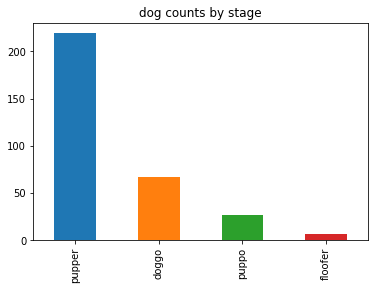

In [66]:
stage_count = df_stage['stage'].value_counts()
stage_count.plot.bar(title ='dog counts by stage', y = 'dog number', x = 'stage')

#### In all rating, the number of pupper is the largest.

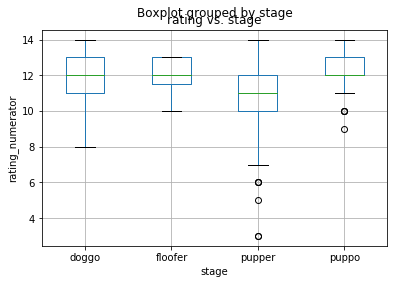

In [67]:
twitter_master.boxplot(column='rating_numerator', by ='stage')
plt.title('rating vs. stage')
plt.ylabel('rating_numerator')
plt.show()

#### The boxplot shows the lowest avarge rating and the lowest rating is pupper stage.

In [68]:
df_favorite = twitter_master[['favorite_count','rating_numerator']]

#there are several outlier number so that just choose the rating numerator less than 40
df_favorite = twitter_master[twitter_master['rating_numerator']<40]

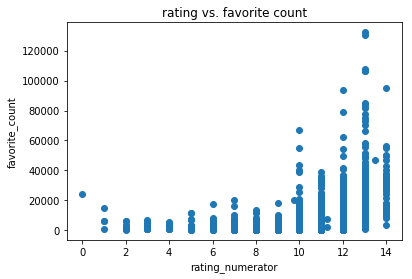

In [69]:
plt.scatter(df_favorite['rating_numerator'],df_favorite['favorite_count'])
plt.xlabel('rating_numerator')
plt.ylabel('favorite_count')
plt.title('rating vs. favorite count')
plt.show()

####  The plot shows the higher rating will get more likes which means there is a positive correlation between the rating and likes.

In [70]:
# change timestampe to datetime type
twitter_master.timestamp = pd.to_datetime(twitter_master.timestamp)

#set timestamp as index
twitter_master_timeseries = twitter_master.set_index(['timestamp'])
twitter_master_timeseries.head()

,tweet_id,source,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
timestamp,,,,,,,,,,,,,,,,,,,,
2017-08-01 16:23:56,892420643555336193,Twitter for iPhone,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8842,39492
2017-08-01 00:17:27,892177421306343426,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6480,33786
2017-07-31 00:18:03,891815181378084864,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4301,25445
2017-07-30 15:58:51,891689557279858688,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8925,42863
2017-07-29 16:00:24,891327558926688256,Twitter for iPhone,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9721,41016


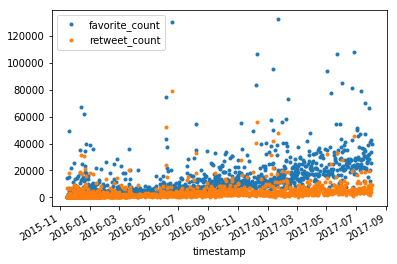

In [71]:
twitter_master_timeseries[['favorite_count', 'retweet_count']].plot(style='.')

#### The favorite count gets more with time, however the retweet count doesn't change a lot.